# This Notebook develops an OLS Regression of CAISO wholesale power prices using scraped generating variables and temporal variables:

In [1]:
import os
print(os.getcwd())

/Users/user/Desktop/CAISO Monthly Prices


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import urllib
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm             # these two imports as used in Boston Housing mini-project
from statsmodels.formula.api import ols

# Illustrative Exploratory Data Analysis using certain developed functions 

In [3]:
H1_18= ['DAM_Jan_2018.csv','DAM_Feb_2018.csv', 'DAM_March_2018.csv','DAM_April_2018.csv','DAM_May_2018.csv','DAM_June_2018.csv']
H2_18= ['DAM_July_2018.csv','DAM_Aug_2018.csv','DAM_Sept_2018.csv','DAM_Oct_2018.csv','DAM_Nov_2018.csv','DAM_Dec_2018.csv']

H1_17= ['DAM_Jan_2017.csv','DAM_Feb_2017.csv', 'DAM_March_2017.csv','DAM_May_2017.csv','DAM_June_2017.csv']
# excludes the missing: 'DAM_April_2017.csv'
H2_17= ['DAM_July_2017.csv','DAM_Aug_2017.csv','DAM_Sept_2017.csv','DAM_Oct_2017.csv','DAM_Nov_2017.csv','DAM_Dec_2017.csv']

def get_price_series(files):
    '''This function prints a list of each of the day that had the lowest power price for the days covered by the files'''
    frames= [ pd.read_csv(file, header= 0, usecols= [0,2,3,9,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')
         for file in files]
    df1= pd.concat(frames)
    dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%
    dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby SPECIFY FORMAT!!
    dfp= dfp.drop(['OPR_DT','LMP_TYPE'],axis=1)
    dfp.columns= ['hour','price','day']
    dfp.index.names= ['date']
    dfp= dfp.sort_index()
    return(dfp)

# graphs mean hourly prices for the subject time period (one line only)
def plot_price_averages(files):
    plt.title('Average Hourly Prices for PGE N.California Hub ($/MWh)')
    plt.ylabel('Price')
    plt.ylabel('Hour of the Day')
    df_pm= get_price_series(H1_17)
    df_pm= df_pm.groupby('hour').price.mean().plot()



def get_hours_histogram(files):
    '''This function prints a list of each of the day that had the lowest power price for the days covered by the files'''
    frames= [ pd.read_csv(file, header= 0, usecols= [0,2,3,9,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')
         for file in files]
    df1= pd.concat(frames)
    dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%
    dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby SPECIFY FORMAT!!
    dfp= dfp.drop(['OPR_DT','LMP_TYPE'],axis=1)
    dfp.columns= ['hour','price','day']
    dfp.index.names= ['date']
    df_pvt= dfp.pivot('day','hour','price') 
    lowest_hours= df_pvt.idxmin(axis=1)       # THIS IS JEFF'S CODE FOR PANDAS SO NO M REQUIRED, NOR ARGMIN()
    plt.hist(lowest_hours, bins= np.arange(1,24,1) - 0.5,density= True)
    plt.title('Histogram of the Hour with the Lowest CAISO Price for the Subject Period ' )
    plt.xlabel('Hour of the Day')
    plt.ylabel('Probability')
    plt.xticks= range(1,25)
    plt.show()
    return pd.Series(lowest_hours).value_counts(sort= False) # this gives the frequencies

In [4]:
def compare_hourly_prices(files1,files2):
    df1= get_price_series(files1) #local variable
    df1= df1.pivot('day','hour','price')
    m1= df1.mean().round(1) # vertical
    df2= get_price_series(files2) #local variable
    df2= df2.pivot('day','hour','price')
    m2= df2.mean().round(1) # vertical
    # now create a df (dfd) to display the actual prices
    dfd= pd.DataFrame()         # pandas.DataFrame.plot
    dfd['first_period']=  m1
    dfd['second_period']= m2
    print(dfd.T.round(1))  # rounds all prices to one decimal places to display better. NEED TO FIX!!
    
    # Pandas plot (but no labelling of axes nor title, but does have a legend)
    dfd.plot() # this works and includes a legend! It appears as the third plot.
    plt.title('Average Hourly Prices for PGE N.California Hub ($/MWh)')
    plt.ylabel('Price')
    plt.xlabel('Hour of the Day')

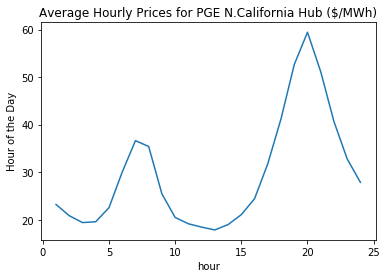

In [5]:
plot_price_averages(H1_17)

hour             1     2     3     4     5     6     7     8     9     10  \
first_period   40.4  37.8  36.1  35.8  37.6  42.4  47.7  45.3  37.6  35.6   
second_period  31.2  29.4  28.6  28.1  28.8  32.0  37.9  37.1  30.0  27.4   

hour           ...     16    17    18    19    20    21    22    23    24  \
first_period   ...   48.0  58.2  72.2  87.6  90.7  69.8  55.3  46.7  42.3   
second_period  ...   39.8  48.1  64.4  80.2  72.7  52.6  42.4  37.2  33.5   

hour             25  
first_period   33.1  
second_period  32.0  

[2 rows x 25 columns]


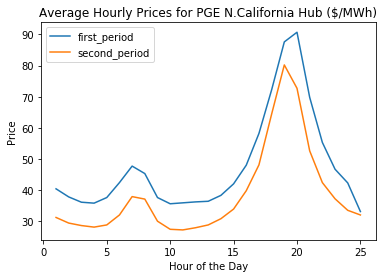

In [6]:
compare_hourly_prices(H2_18,H2_17) # prices much higher in 2018, despite more solar

hour             1     2     3     4     5     6     7     8     9     10  \
first_period   26.0  24.2  23.0  22.7  24.5  30.3  36.8  31.7  23.6  19.8   
second_period  40.4  37.8  36.1  35.8  37.6  42.4  47.7  45.3  37.6  35.6   

hour           ...     15    16    17    18    19    20    21    22    23  \
first_period   ...   17.2  20.2  25.1  33.9  43.3  49.8  48.8  40.0  32.3   
second_period  ...   42.0  48.0  58.2  72.2  87.6  90.7  69.8  55.3  46.7   

hour             24  
first_period   28.3  
second_period  42.3  

[2 rows x 24 columns]


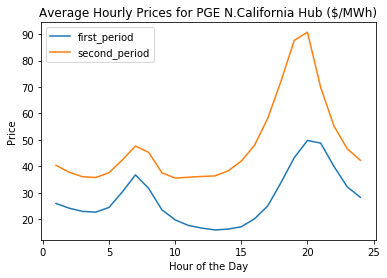

In [7]:
compare_hourly_prices(H1_18,H2_18) # prices much higher in H2, as A/C load perhaps outweighs the Solar PV benefit
# Incidentally, with such very high Peak Hours prices in H2_2018, one can intuit why prediction may be more difficult?

# The lowest overnight power prices (most relevant for home EV charging) are concentrated in just two hours

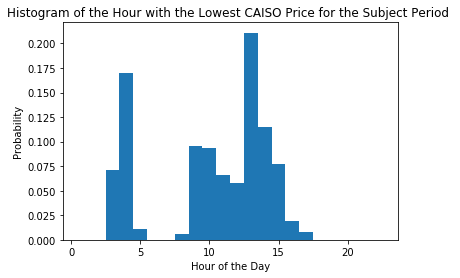

3     26
4     62
5      4
8      2
9     35
10    34
11    24
12    21
13    77
14    42
15    28
16     7
17     3
dtype: int64

In [8]:
# Histogram of Lowest Prices for 2018 
full_year_18= H1_18 + H2_18
get_hours_histogram(full_year_18)

# ...and this pattern holds for 2017 & 2018 combined

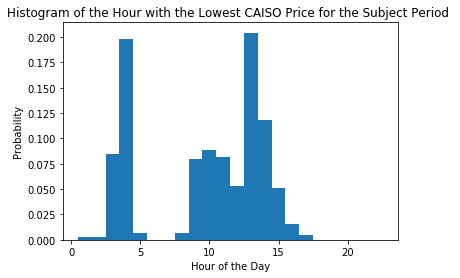

1       2
2       2
3      59
4     139
5       5
8       5
9      56
10     62
11     57
12     37
13    143
14     83
15     36
16     11
17      3
dtype: int64

In [9]:
# Histogram of Lowest Prices for 2017 & 2018 combined
two_years= H1_17 + H2_17 + H1_18 + H2_18
get_hours_histogram(two_years)

# For an EV owner charging exclusively in the above-identified lowest-price hours, versus the (conventional) onset of the Off_Peak period, the wholesale price was c.53% lower in 2018

In [10]:
# Comparison of DAM Prices at Hours 3 & 4 with PGE Off-Peak Onset
full_year_18= H1_18 + H2_18

def get_price_discount(files):
    dfp= get_price_series(files)
    g= dfp.groupby(by= dfp['hour'])
    dfh= g.price.mean()
    print(dfh.T.round(2))
    discount= 100 * (1 - (dfh[2]+ dfh[3])/(dfh[20]+ dfh[21]))
    print('Average Percent Saving of Lowest-Price hours versus the onset of Off-Peak', round(discount,1), '%')
#Commentary
#With the PG&E off-peak period starting at 9pm (which is "Hour 22"), the average price for two hours of charging
#is simply the average of the respective prices. This may be compared to the average prices for Hours 3 & 4. 
#As calculated above, the Average Percent Saving of Lowest-Price hours versus the onset of Off-Peak is c.53%.


In [11]:
get_price_discount(full_year_18)

hour
1     33.30
2     31.06
3     29.62
4     29.29
5     31.10
6     36.40
7     42.28
8     38.55
9     30.68
10    27.77
11    26.88
12    26.51
13    26.26
14    27.38
15    29.74
16    34.17
17    41.78
18    53.19
19    65.66
20    70.41
21    59.42
22    47.72
23    39.56
24    35.36
25    33.13
Name: price, dtype: float64
Average Percent Saving of Lowest-Price hours versus the onset of Off-Peak 53.3 %


# Scraping the CAISO Daily Reports for power generation by type

In [12]:
# Although models have developed to predict California power prices, thet have rarely 
# used hourly generation of the type scraped here.
def read_one_day(date):
    link = "http://content.caiso.com/green/renewrpt/{}_DailyRenewablesWatch.txt".format(date)
    url = urllib.request.urlopen(link)
    content = [str(word) for word in url.readlines()] # converting each word of each line to strings

    # Note these are static, so may need to be adjusted.  Looks to be the same each day though.
    # Could be possible to parse on the fly, but start simple for now
    renewable_columns = ['hour', 'geo', 'biom', 'biog', 'shydro', 'wind', 'solarPV', 'sTH']
    renewable_data = content[2:26]    
    total_columns = ['hour', 'srnwbls','nucl', 'thermal', 'imports', 'lhydro']
    total_data = content[30:]    
    
    parsed_renewable = [parse_array(row) for row in renewable_data] # calling function below w 3 Regular Expression calls
    parsed_total = [parse_array(row) for row in total_data] # same
    
    renewable = pd.DataFrame(parsed_renewable, columns=renewable_columns)
    total = pd.DataFrame(parsed_total, columns=total_columns)
    
    renewable['DATE'] = date
    total['DATE'] = date
    df= pd.merge(renewable,total,on= 'hour')  # s = pd.Series(["a", "b", "c", "a"], dtype="category")//pd.series( ,dtype= 'category') rejected
    df.hour= ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
    df['DT'] = pd.to_datetime(df['DATE_y'] + ' ' + df['hour'] + ':00:00')
    df.set_index(df['DT'], inplace= True)
    df= df.drop(['DATE_x','DATE_y','DT'], axis=1)
    # df['hour']= df['hour'].astype('category', ordered=True)# categories=[2, 1]
    # FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
    return df
    
def parse_array(one_row):
    no_chars = re.sub(r"[a-zA-Z']", "", one_row) # were commas used to denote thousands (so needed to be removed)
    no_slashes = re.sub(r"\\+", ",", no_chars)
    splitted_strings = no_slashes[1:-1].split(',')
    return [int(elem) for elem in splitted_strings] # interesting syntax! return a List Comprehension!
# after parsing numbers converted back to numeric for Pandas read

In [13]:
def read_one_month(year_month):  # see datetime lectures Chapter 4
    if year_month[4:6] in ['04','06','09','11']:
        d= 31
    elif year_month[4:6] == '02':
        d=29
    else:
        d=32
    month_dates_A= [(year_month + '0' + str(i)) for i in list(range(1,10))]
    month_dates_B= [(year_month + str(i)) for i in list(range(10,d))]
    month_dates= month_dates_A + month_dates_B
    dfs= [read_one_day(date) for date in month_dates] #dfs for dataframeS
    dfc= pd.concat(dfs)   
    return dfc

# Scraping the Daily Data into six-month periods and writing to file

In [14]:
# first six months of 2018 (H1 2018)

H1_18_gen_dates= [('2018'+ rest) for rest in ['01','02','03','04','05','06']]
H1_18_gen_dates

H1_18_gen_dfs= [read_one_month(month) for month in H1_18_gen_dates]     # response ONLY after two minutes!
H1_18_gen_dfs[0] # H1_18_gen_files is a list of df's

H1_18_gen_data = pd.concat(H1_18_gen_dfs)
print(H1_18_gen_data.head(3))
H1_18_gen_data.info()
print(H1_18_gen_data.tail(3))


                    hour  geo  biom  biog  shydro  wind  solarPV  sTH  \
DT                                                                      
2018-01-01 00:00:00   00  975   304   214     299   236        0    0   
2018-01-01 01:00:00   01  976   304   215     301   277        0    0   
2018-01-01 02:00:00   02  975   304   216     301   128        0    0   

                     srnwbls  nucl  thermal  imports  lhydro  
DT                                                            
2018-01-01 00:00:00     2028  2260     7236     7501    2102  
2018-01-01 01:00:00     2073  2259     6702     7453    2043  
2018-01-01 02:00:00     1924  2260     6266     7498    2033  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4344 entries, 2018-01-01 00:00:00 to 2018-06-30 23:00:00
Data columns (total 13 columns):
hour       4344 non-null object
geo        4344 non-null int64
biom       4344 non-null int64
biog       4344 non-null int64
shydro     4344 non-null int64
wind       4344 non-

In [15]:
# write to a csv file for storage for convenient future use (and if ever removed from CAISO website)
H1_18_gen_data = H1_18_gen_data.to_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H1_18_gen_data.csv', 
                                        index = 'DT', header=True) 


# H1_17 below does not run due to stray decimal: read/parse as float?

# first six months of 2017 (H1 2017)
H1_17_gen_dates= [('2017'+ rest) for rest in ['01','02','03','04','05','06']]
H1_17_gen_dates

H1_17_gen_dfs= [read_one_month(month) for month in H1_17_gen_dates]     # response ONLY after two minutes!
H1_17_gen_dfs[0] # H1_17_gen_files is a list of df's

H1_17_gen_data = pd.concat(H1_17_gen_dfs)
print(H1_17_gen_data.head(3))
H1_17_gen_data.info()
print(H1_17_gen_data.tail(3))   # ValueError: invalid literal for int() with base 10: '"  

In [16]:
# second six months of 2018 (H2 2018)
H2_18_gen_dates= [('2018'+ rest) for rest in ['07','08','09','10','11','12']]
H2_18_gen_dates

H2_18_gen_dfs= [read_one_month(month) for month in H2_18_gen_dates]     # response ONLY after two minutes!
H2_18_gen_dfs[0] # a list of df's

H2_18_gen_data = pd.concat(H2_18_gen_dfs)
print(H2_18_gen_data.head(3))
H2_18_gen_data.info()
print(H2_18_gen_data.tail(3))  

                    hour  geo  biom  biog  shydro  wind  solarPV  sTH  \
DT                                                                      
2018-07-01 00:00:00   00  992   342   223     347  4087        0    0   
2018-07-01 01:00:00   01  994   343   223     341  4053        0    0   
2018-07-01 02:00:00   02  994   344   223     310  3919        0    0   

                     srnwbls  nucl  thermal  imports  lhydro  
DT                                                            
2018-07-01 00:00:00     5991  2268     7648     6776    2585  
2018-07-01 01:00:00     5954  2267     6245     7007    2400  
2018-07-01 02:00:00     4796  2259     6286     7170    2360  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-07-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 13 columns):
hour       4416 non-null object
geo        4416 non-null int64
biom       4416 non-null int64
biog       4416 non-null int64
shydro     4416 non-null int64
wind       4416 non-

In [17]:
# write to a csv file for storage for convenient future use
H2_18_gen_data = H2_18_gen_data.to_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H2_18_gen_data.csv', 
                                        index = 'DT', header=True) 

In [18]:
H2_17_gen_dates= [('2017'+ rest) for rest in ['07','08','09','10','11','12']]
H2_17_gen_dates

H2_17_gen_dfs= [read_one_month(month) for month in H2_17_gen_dates]     # response ONLY after two minutes!
H2_17_gen_dfs[0] # a list of df's

H2_17_gen_data = pd.concat(H2_17_gen_dfs)
print(H2_17_gen_data.head(3))
H2_17_gen_data.info()
print(H2_17_gen_data.tail(3))

                    hour   geo  biom  biog  shydro  wind  solarPV  sTH  \
DT                                                                       
2017-07-01 00:00:00   00  1025   226   184     482  3629        0    0   
2017-07-01 01:00:00   01  1025   226   184     481  3575        0    0   
2017-07-01 02:00:00   02  1025   228   185     477  3630        0    0   

                     srnwbls  nucl  thermal  imports  lhydro  
DT                                                            
2017-07-01 00:00:00     5514  2277     6182     7510    4075  
2017-07-01 01:00:00     5491  2278     4715     7377    4074  
2017-07-01 02:00:00     5545  2278     3625     7411    4068  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2017-07-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 13 columns):
hour       4416 non-null object
geo        4416 non-null int64
biom       4416 non-null int64
biog       4416 non-null int64
shydro     4416 non-null int64
wind       4416

In [19]:
# write to a csv file for storage for convenient future use
H2_17_gen_data = H2_17_gen_data.to_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H2_17_gen_data.csv', 
                                       index= 'DT', header=True) 

In [20]:
# Reading the data written to file for storage

In [21]:
H2_18G = pd.read_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H2_18_gen_data.csv',index_col= 'DT')

In [22]:
H1_18G = pd.read_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H1_18_gen_data.csv',index_col= 'DT')

H2_17G = pd.read_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H2_17_gen_data.csv', index_col= 'DT') 

# California-time Price data

In [23]:
def get_price_series(files):
    '''This function reads the CAISO prices and adjusts time from UTZ to local CA time, consistent with the scraped data '''
    frames= [ pd.read_csv(file, header= 0, usecols= [0,2,3,9,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')
         for file in files]
    df1= pd.concat(frames)
    dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%
    dfp['date']= pd.to_datetime(dfp['OPR_DT']) #needed for plotting after the groupby SPECIFY FORMAT!!
    dfp= dfp.drop(['OPR_DT','LMP_TYPE'],axis=1)
    dfp.columns= ['hour','price','day']
    dfp.index.names= ['date']
    dfp= dfp.sort_index()
    dfp.index= dfp.index.values - pd.Timedelta(hours=8) # via Sankar
    return(dfp)

In [24]:
get_price_series(H1_18).head(3) # indeed correctly changed to 00: from 08:00:00

,hour,price,day
2018-01-01 00:00:00,1,36.45428,2018-01-01
2018-01-01 01:00:00,2,34.76417,2018-01-01
2018-01-01 02:00:00,3,32.85036,2018-01-01


In [25]:
get_price_series(H1_17).head(3) # OK

,hour,price,day
2017-01-01 00:00:00,1,32.19913,2017-01-01
2017-01-01 01:00:00,2,32.06740,2017-01-01
2017-01-01 02:00:00,3,31.92218,2017-01-01


In [26]:
get_price_series(H2_18).head(3) # OK, No Length mismatch:eg"Expected axis has 25 elements, new values have 24 elements
# But note due to timechange first datesamp is actually 23:00 !!!

,hour,price,day
2018-06-30 23:00:00,1,30.14863,2018-07-01
2018-07-01 00:00:00,2,28.91507,2018-07-01
2018-07-01 01:00:00,3,28.04430,2018-07-01


In [27]:
get_price_series(H2_17).head(3) # But note due to timechange first datesamp is actually 23:00 !!!

,hour,price,day
2017-06-30 23:00:00,1,30.45000,2017-07-01
2017-07-01 00:00:00,2,25.01777,2017-07-01
2017-07-01 01:00:00,3,27.22040,2017-07-01


In [28]:
dfpc= pd.concat([get_price_series(H1_18),get_price_series(H2_18)]) # Prices Consolidated for 2018

In [29]:
# Now concatenate generating data for 2018

In [30]:
dfg_H1_18 = pd.read_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H1_18_gen_data.csv',index_col= 'DT')
dfg_H2_18 = pd.read_csv(r'C:\Users\user\Desktop\CAISO Monthly Prices\H2_18_gen_data.csv',index_col= 'DT')


In [31]:
dfgc= pd.concat([dfg_H1_18, dfg_H2_18]) # Generating data Consolidated for 2018

In [32]:
dfgc.index = pd.to_datetime(dfgc.index) # required as dates still strings (aka objects)

In [33]:
# dfc= pd.merge(df,dfp, how= 'inner', left_on= df.index, right_on= dfp.index)
dfc= pd.merge(dfpc, dfgc, how= 'inner', left_on= dfpc.index, right_on= dfgc.index)
dfc.head() 

,key_0,hour_x,price,day,hour_y,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro
0,2018-01-01 00:00:00,1,36.45428,2018-01-01,0,975,304,214,299,236,0,0,2028,2260,7236,7501,2102
1,2018-01-01 01:00:00,2,34.76417,2018-01-01,1,976,304,215,301,277,0,0,2073,2259,6702,7453,2043
2,2018-01-01 02:00:00,3,32.85036,2018-01-01,2,975,304,216,301,128,0,0,1924,2260,6266,7498,2033
3,2018-01-01 03:00:00,4,31.64637,2018-01-01,3,974,303,215,301,82,0,0,1875,2261,6191,7333,1958
4,2018-01-01 04:00:00,5,31.80000,2018-01-01,4,974,305,215,301,127,0,0,1922,2261,6384,7026,2046


In [34]:
dfc['load']= dfc['srnwbls'] + dfc['nucl'] + dfc['thermal'] + dfc['imports'] + dfc['lhydro']
dfc['weekday']= dfc.key_0.dt.weekday_name
dfc['month']= dfc.key_0.dt.month
dfc= dfc.drop(['day','hour_y'], axis=1)
dfc.head()

,key_0,hour_x,price,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro,load,weekday,month
0,2018-01-01 00:00:00,1,36.45428,975,304,214,299,236,0,0,2028,2260,7236,7501,2102,21127,Monday,1
1,2018-01-01 01:00:00,2,34.76417,976,304,215,301,277,0,0,2073,2259,6702,7453,2043,20530,Monday,1
2,2018-01-01 02:00:00,3,32.85036,975,304,216,301,128,0,0,1924,2260,6266,7498,2033,19981,Monday,1
3,2018-01-01 03:00:00,4,31.64637,974,303,215,301,82,0,0,1875,2261,6191,7333,1958,19618,Monday,1
4,2018-01-01 04:00:00,5,31.80000,974,305,215,301,127,0,0,1922,2261,6384,7026,2046,19639,Monday,1


In [35]:
dfc.index= dfc['key_0']
dfc.index.names= ['date']
dfc= dfc.rename(columns= {'hour_x': 'hour'})

dfc['hour']= dfc['hour'].astype('category')
dfc['weekday']= dfc['weekday'].astype('category')
dfc['month']= dfc['month'].astype('category')
# dfc['hour']= dfc['hour'].astype('str')
dfc= dfc.drop(['key_0'], axis=1)
dfc.info()
dfc.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 17 columns):
hour       8760 non-null category
price      8760 non-null float64
geo        8760 non-null int64
biom       8760 non-null int64
biog       8760 non-null int64
shydro     8760 non-null int64
wind       8760 non-null int64
solarPV    8760 non-null int64
sTH        8760 non-null int64
srnwbls    8760 non-null int64
nucl       8760 non-null int64
thermal    8760 non-null int64
imports    8760 non-null int64
lhydro     8760 non-null int64
load       8760 non-null int64
weekday    8760 non-null category
month      8760 non-null category
dtypes: category(3), float64(1), int64(13)
memory usage: 1.0 MB


,hour,price,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro,load,weekday,month
date,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1,36.45428,975,304,214,299,236,0,0,2028,2260,7236,7501,2102,21127,Monday,1
2018-01-01 01:00:00,2,34.76417,976,304,215,301,277,0,0,2073,2259,6702,7453,2043,20530,Monday,1
2018-01-01 02:00:00,3,32.85036,975,304,216,301,128,0,0,1924,2260,6266,7498,2033,19981,Monday,1


In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# import statsmodels.formula.api as smf
m= ols(formula= 'price ~ load + wind + solarPV + nucl + thermal + imports + lhydro + hour + weekday + month',
       data= dfc).fit()  # .fit() already done (chained)

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     172.7
Date:                Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:30:08   Log-Likelihood:                -39494.
No. Observations:                8760   AIC:                         7.909e+04
Df Residuals:                    8711   BIC:                         7.943e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -8.6208 

# Commentary
All variables except Thermal and Large Hydro have statistically significant t-values, and the negative sign of Thermal is also counterintuitive (while the signs of the other variables are intuitive).
When we drop thermal, we see that the t-value for 'imports' is now highly significant.
With an adjusted R-squared of 49% [is far below the 85% for H1 alone]. 
The values of the dummy variables for 'month' suggest January has has higher prices than most other months (solar adjustment??). compare this to a monthly groupby()

In [37]:
m2= ols(formula= 'price ~ load + wind + solarPV + nucl + imports + hour + weekday + month',data= dfc).fit()
#.fit() already done (chained)

print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     180.2
Date:                Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:30:08   Log-Likelihood:                -39495.
No. Observations:                8760   AIC:                         7.908e+04
Df Residuals:                    8713   BIC:                         7.942e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.9838 

# For purposes of comparison, a 'temporal' model is fitted that uses exclusively temporal variables of hour, weekday, and month

In [38]:
m2_temporal= ols(formula= 'price ~ hour + weekday + month', data= dfc).fit()  # .fit() already done (chained)
print(m2_temporal.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     102.9
Date:                Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:30:08   Log-Likelihood:                -40694.
No. Observations:                8760   AIC:                         8.147e+04
Df Residuals:                    8718   BIC:                         8.177e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               27.6458 

# Off-Peak Hours Only Model

In [39]:
dfw= dfc[dfc['hour'].isin([1, 2,3,4,5,23,24])] # Odd, strings not accepted, so not strings but Categorical
dfw.head(3)

,hour,price,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,thermal,imports,lhydro,load,weekday,month
date,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1,36.45428,975,304,214,299,236,0,0,2028,2260,7236,7501,2102,21127,Monday,1
2018-01-01 01:00:00,2,34.76417,976,304,215,301,277,0,0,2073,2259,6702,7453,2043,20530,Monday,1
2018-01-01 02:00:00,3,32.85036,975,304,216,301,128,0,0,1924,2260,6266,7498,2033,19981,Monday,1


In [40]:
mw= ols(formula= 'price ~ load+ wind + solarPV +  thermal + imports + lhydro + hour + weekday + month', data= dfw).fit()
print(mw.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     274.8
Date:                Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:30:08   Log-Likelihood:                -8009.0
No. Observations:                2554   AIC:                         1.608e+04
Df Residuals:                    2524   BIC:                         1.625e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               31.3515 

In [41]:
mw1= ols(formula= 'price ~  wind +  thermal + imports + lhydro + hour + weekday + month', data= dfw).fit()
print(mw1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     272.6
Date:                Mon, 04 Mar 2019   Prob (F-statistic):               0.00
Time:                        17:30:08   Log-Likelihood:                -8086.1
No. Observations:                2554   AIC:                         1.623e+04
Df Residuals:                    2526   BIC:                         1.639e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               13.8069 

# Train/Test Split w scikit.learn

In [57]:
print(dfw.shape)
dfw.info()
dfw = pd.get_dummies(dfw) # creating dummy variables from all Categorical variables in scikit learn 
dfw.head(3)

(2554, 58)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2554 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 58 columns):
price                2554 non-null float64
geo                  2554 non-null int64
biom                 2554 non-null int64
biog                 2554 non-null int64
shydro               2554 non-null int64
wind                 2554 non-null int64
solarPV              2554 non-null int64
sTH                  2554 non-null int64
srnwbls              2554 non-null int64
nucl                 2554 non-null int64
thermal              2554 non-null int64
imports              2554 non-null int64
lhydro               2554 non-null int64
load                 2554 non-null int64
hour_1               2554 non-null uint8
hour_2               2554 non-null uint8
hour_3               2554 non-null uint8
hour_4               2554 non-null uint8
hour_5               2554 non-null uint8
hour_6               2554 non-null uint8
hour_7               255

,price,geo,biom,biog,shydro,wind,solarPV,sTH,srnwbls,nucl,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,36.45428,975,304,214,299,236,0,0,2028,2260,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 01:00:00,34.76417,976,304,215,301,277,0,0,2073,2259,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 02:00:00,32.85036,975,304,216,301,128,0,0,1924,2260,...,0,0,0,0,0,0,0,0,0,0


In [58]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [59]:
y = dfw[['price']] # define the target variable (dependent variable) as y
X = dfw.drop('price', axis=1)

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2043, 57) (2043, 1)
(511, 57) (511, 1)


In [60]:
# mw= ols(formula= 'price ~ load+ wind + solarPV +  thermal + imports + lhydro + hour + weekday + month', data= dfw).fit()
# Backdoor way to specify is to subset X with the desired columns BEFORE Train/Test Split

In [61]:
lm = linear_model.LinearRegression() # fit a model 
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

Score: 0.7935649728047184


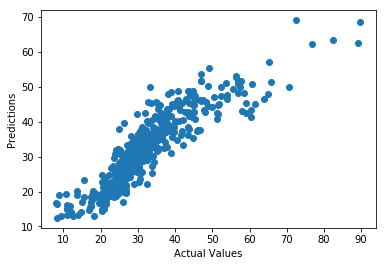

In [55]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
print('Score:', model.score(X_test, y_test))


# Old and Discarded Code

# Comparison of DAM Prices at Hours 3 & 4 with PGE Off-Peak Onset
g= dfp.groupby(by= dfp['hour'])
dfh= g.price.mean()
type(dfh) # pandas.core.series.Series
print(dfh)
print(dfh[3])
discount= 100 * (1 - (dfh[3]+ dfh[4])/(dfh[22]+ dfh[23]))
print('Average Percent Saving of Lowest-Price hours versus the onset of Off-Peak', round(discount,1), '%')
#Commentary
#With the PG&E off-peak period starting at 9pm (which is "Hour 22"), the average price for two hours of charging
#is simply the average of the respective prices. This may be compared to the average prices for Hours 3 & 4. 
#As calculated above, the Average Percent Saving of Lowest-Price hours versus the onset of Off-Peak is c.37%.

# Concat generating data

dfgc= pd.concat([H2_17G, H1_18G,H2_18G]) #dfgc is the df's Generating Consolidated, here spanning 18 months

print(len(dfgc)) # the number of hours spanned (here for 18 months)
dfc.head(3)

# we need to merge with CAISO prices! (DT is still a column and load is already introduced as a variable)

dfpc= pd.concat([get_price_series(H2_17),get_price_series(H1_18),get_price_series(H2_18)])# Prices Consolidated

dfpc.head(2)
dfpc.hour= dfpc.hour.astype('category') # even though now a categorical variable, still no broadcasting!
from datetime import timedelta
dfpc.info()
dfpc= dfpc.pivot(index= 'day',columns= 'hour', values= 'price')

dfpc.columns= ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19',
            '20','21','22','23','25'] # ValueError: Length of values does not match length of index: NO BROADCASTING!!

dft_index= dft.index.values  # Sankar
dft_index_new= dft_index - pd.Timedelta(hours=8)
dft.index = dft_index_new

# THIS IS A CONVOLUTED FUNCTION I WROTE TO CHANGE THE DATETIME INDEX TO MATCH THE GENERATING DATA
# REPLACED WITH JUST ONE LINE:    dfp.index= dfp.index.values - pd.Timedelta(hours=8) # Sankar

H1_18= ['DAM_Jan_2018.csv','DAM_Feb_2018.csv', 'DAM_March_2018.csv','DAM_April_2018.csv','DAM_May_2018.csv','DAM_June_2018.csv']
def get_CAtime_price_series(files):
    frames= [ pd.read_csv(file, header= 0, usecols= [0,2,3,9,14],parse_dates= True, index_col= 'INTERVALSTARTTIME_GMT')
         for file in files]
    df1= pd.concat(frames)
    dfp= df1[df1['LMP_TYPE'] == 'LMP'] # drops the other four price components and reduces data rows by 80%
    dfp['date']= dfp['OPR_DT'] 
    dfp= dfp.drop(['OPR_DT','LMP_TYPE'],axis=1)
    dfp.columns= ['hour','price','day']
    dfp.head(2)
    dfp.index.names= ['date']
    dfp= dfp.sort_index()
    # dfp= dfp.sort_values
    df_pvt= dfp.pivot('day','hour','price') # Hmm: already vertical column so pivot() makes HORIZONTAL
    # print(df_pvt.head(3)) drop this as this FN() is called elsewhere
    df_pvt.columns= ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19',
            '20','21','22','23'] 
    df_pvt.tail(3)
    dft= df_pvt.stack()
    dft=dft.reset_index()
    dft.columns= ['day','hour','price'] # where 'day'  is string, not DT
    dft['date']= pd.to_datetime(dft['day'] + ' ' + dft['hour'] + ':00:00')
    from datetime import datetime
    dft['weekday']= dft.date.dt.weekday_name
    dft['month']= dft.date.dt.month
    dft.set_index(dft['date'], inplace= True)
    dft= dft.drop(['day','date'], axis=1)
    dft['hour']= dft['hour'].astype('category')
    dft['weekday']= dft['weekday'].astype('category')
    dft['month']= dft['month'].astype('category')
    return dft